In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import re
import seaborn as sns

Notebooks
1. [FastText](https://www.kaggle.com/code/vsmolyakov/keras-cnn-with-fasttext-embeddings)
2.[Best Score](https://www.kaggle.com/code/rhodiumbeng/classifying-multi-label-comments-0-9741-lb)
3. [EDA](https://www.kaggle.com/code/akkefa/eda-toxic-comment-classification-challenge)

In [2]:
train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
sample_submission = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')

### Params

In [3]:
maxlen = 69
num_words = 10000
embedding_dim = 100

## EDA

In [4]:
print(len(train), len(test))
display(train.head(7))

159571 153164


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


In [5]:
print(train.isnull().sum())
print("\n")
print(test.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


id              0
comment_text    0
dtype: int64


As we see, there is no missing row in the dataset.

Let's clean up the text entries in the dataset.

Let's get the distribution of word counts in the texts

In [6]:
texts = train['comment_text'].values.tolist()

columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels = train[columns].values.tolist()

texts[0], labels[0]

("Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 [0, 0, 0, 0, 0, 0])

Text(0.5, 1.0, 'Word Frequency Distribution in Train dataset')

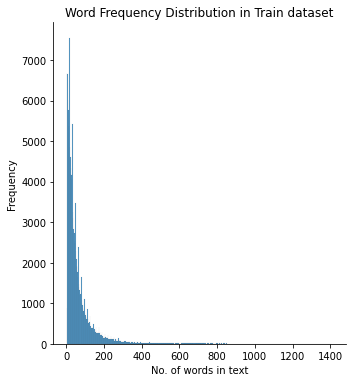

In [7]:
# let's get the distribution of word counts in the corpus

text_size = list(map(lambda x: len(x.split()), texts))
sns.displot(text_size)
plt.xlabel('No. of words in text')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in Train dataset')

In [8]:
mean = pd.Series(text_size).mean()
maxx = pd.Series(text_size).max()

print(f"The average number of words per entry is {mean}")
print(f"The maximum number of words in all entries is {maxx}")

The average number of words per entry is 67.27352714465661
The maximum number of words in all entries is 1411


In [9]:
# let's see the categories distribution

cat_counts = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
cat_counts

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

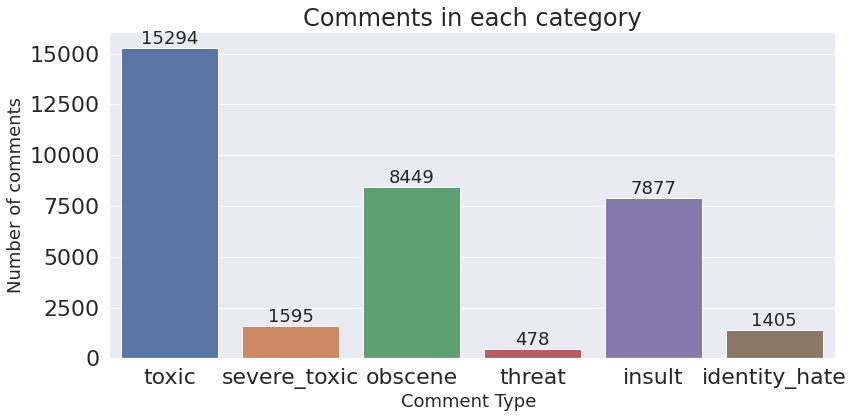

In [10]:
import seaborn as sns

categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

sns.set(font_scale = 2)
plt.figure(figsize=(13,6))

ax= sns.barplot(x=categories, y=train.iloc[:,2:].sum().values)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)

#adding the text labels
rects = ax.patches
labelss = train.iloc[:,2:].sum().values
for rect, label in zip(rects, labelss):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

63042228


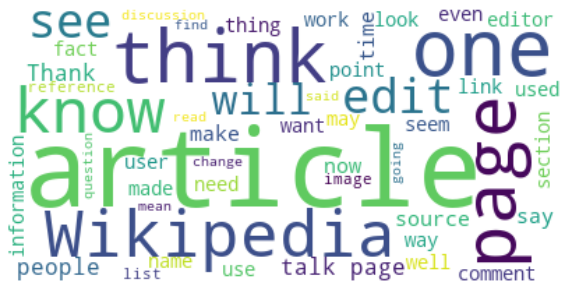

In [11]:
# let's see some of the words in the dataset

from wordcloud import WordCloud

corpus = ' '.join(text for text in texts)
print(len(corpus))

wordcloud = WordCloud(width=400, max_words = 50, background_color = 'white')
wordcloud.generate(corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

That didn't help much, let's generate the wordcloud by toxic comment category

In [12]:
def word_plot(column, text):
    comments = str(train['comment_text'].loc[column == 1].values)
    
    wordcloud = WordCloud(width=400, max_words = 50, background_color = 'white')
    wordcloud.generate(comments)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most common words in {text}")
    print("\n")
    
    plt.show()

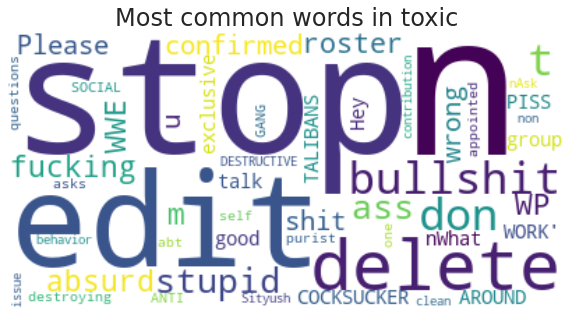

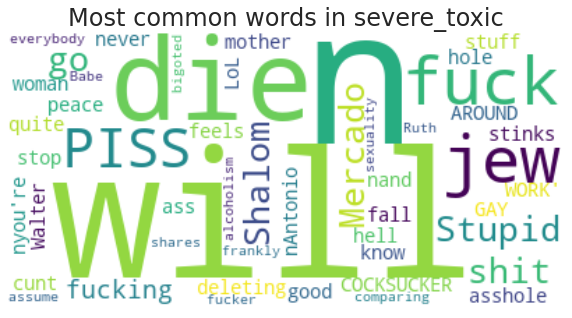

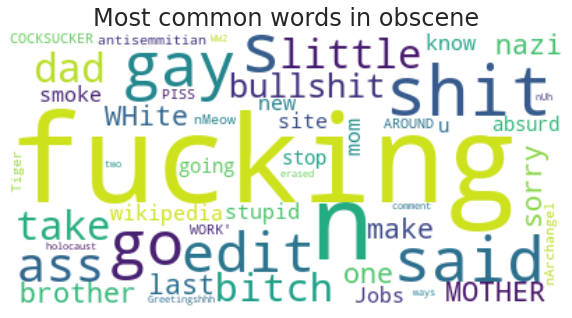

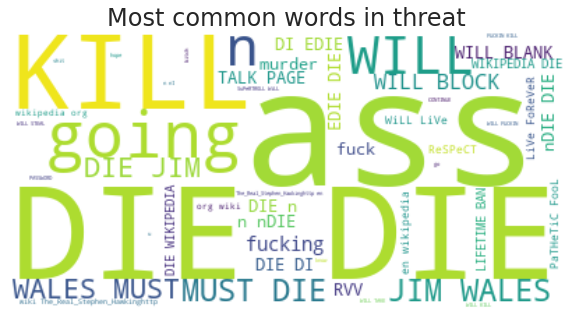

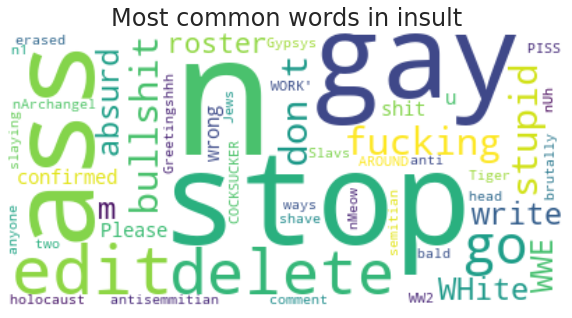

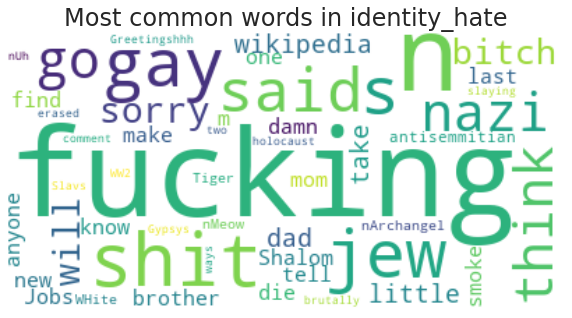

In [13]:
word_plot(train['toxic'], "toxic")
word_plot(train['severe_toxic'], "severe_toxic")
word_plot(train['obscene'], "obscene")
word_plot(train['threat'], "threat")
word_plot(train['insult'], 'insult')
word_plot(train['identity_hate'], 'identity_hate')

## Tokenization

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
vocab_size = len(word_index)
sequences = tokenizer.texts_to_sequences(texts)

In [15]:
print(texts[0], sequences[0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27 [688, 75, 1, 126, 130, 177, 29, 672, 4511, 1116, 86, 331, 51, 2278, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]


In [16]:
# let's pad the sequences to a constant length
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences = pad_sequences(sequences, maxlen = maxlen)

In [17]:
sequences[0], sequences[0].shape

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  688,   75,    1,  126,  130,  177,   29,  672,
        4511, 1116,   86,  331,   51, 2278,   50, 6864,   15,   60, 2756,
         148,    7, 2937,   34,  117, 1221, 2825,    4,   45,   59,  244,
           1,  365,   31,    1,   38,   27,  143,   73, 3462,   89, 3085,
        4583, 2273,  985], dtype=int32),
 (69,))

Let's bring the text dataset up to this level

In [18]:
test_texts = test['comment_text'].values
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences = pad_sequences(test_sequences, maxlen)

In [19]:
print(test_sequences[0])
tokenizer.sequences_to_texts([test_sequences[0]])

[   0    0    0 2665  655 8849  656    8   57   83  884  356   16 3222
   76   21    6    4 6865    6 1521    7   56  655 4942 1898  682 6908
    4   96    6    2 5104   29  417    6  726   35 8849  656    8   36
 4122   10 2818  660  437  454    9  333   15  153    4    8  240   49
   52   24    5 2045  162 3132  682 2880   96  219  145  493   84]


["yo bitch ja rule is more then you'll ever be whats up with you and hating you sad i should bitch slap ur white faces and get you to kiss my ass you guys me ja rule is about pride in da music man dont that shit on him and is wrong like he was a brother too fuckin white boys get things right next time"]

In [20]:
labels = np.array(labels)
labels.shape

(159571, 6)

In [21]:
# sanity check
print(texts[0])
print(sequences[0])
print(tokenizer.sequences_to_texts([sequences[0]]))
print(labels[0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  688   75    1
  126  130  177   29  672 4511 1116   86  331   51 2278   50 6864   15
   60 2756  148    7 2937   34  117 1221 2825    4   45   59  244    1
  365   31    1   38   27  143   73 3462   89 3085 4583 2273  985]
["explanation why the edits made under my username hardcore fan were reverted they weren't just closure on some gas after i voted at new york fac and please don't remove the template from the talk page since i'm retired now 89 205 38 27"]
[0 0 0 0 0 0]


## ML Model

For the modelling part, we'll try different approaches which include:

1. simple model built from scratch
2. try a simple transformer architecture built using Keras layers
3. improve results from above by using pretrained embeddings
4. Load BERT weights from HuggingFace transformers 

#### Simple Model from scratch

In [22]:
model = models.Sequential(name = 'baseline_model')
model.add(layers.Embedding(input_dim = num_words, output_dim = embedding_dim, input_length = maxlen))
model.add(layers.LSTM(64, dropout=0.2, return_sequences = False))
model.add(layers.Dense(6, activation = 'sigmoid'))

2023-01-07 20:35:23.749217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 20:35:23.914302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 20:35:23.915204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 20:35:23.916606: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [23]:
model.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 69, 100)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 1,042,630
Trainable params: 1,042,630
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='adam', metrics = ['acc'], loss = 'binary_crossentropy')

In [25]:
history = model.fit(sequences, labels, epochs = 5, validation_split = 0.1)

Epoch 1/5


2023-01-07 20:35:27.225711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-07 20:35:30.288835: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4488/4488 [==============================] - 35s 7ms/step - loss: 0.0650 - acc: 0.9863 - val_loss: 0.0542 - val_acc: 0.9940
Epoch 2/5
4488/4488 [==============================] - 30s 7ms/step - loss: 0.0475 - acc: 0.9938 - val_loss: 0.0516 - val_acc: 0.9939
Epoch 3/5
4488/4488 [==============================] - 32s 7ms/step - loss: 0.0426 - acc: 0.9849 - val_loss: 0.0504 - val_acc: 0.9934
Epoch 4/5
4488/4488 [==============================] - 33s 7ms/step - loss: 0.0384 - acc: 0.9757 - val_loss: 0.0516 - val_acc: 0.9883
Epoch 5/5
4488/4488 [==============================] - 30s 7ms/step - loss: 0.0346 - acc: 0.9600 - val_loss: 0.0546 - val_acc: 0.9890


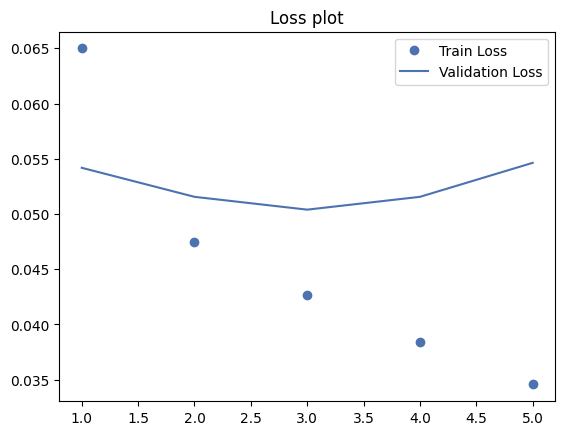

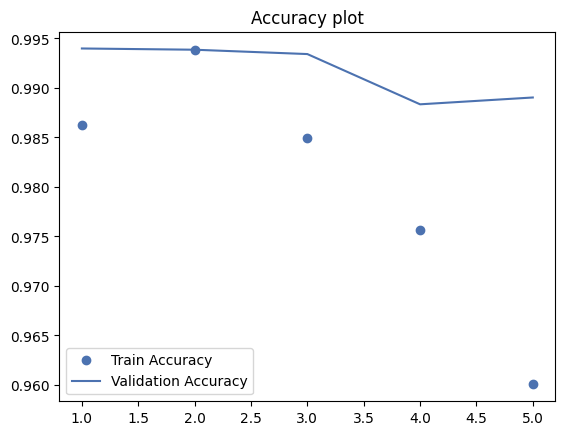

In [26]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) # reset style back to default

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss)+ 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Train Loss')
plt.plot(epochs, val_loss, 'b-', label = 'Validation Loss')
plt.title('Loss plot')
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'bo', label = 'Train Accuracy')
plt.plot(epochs, val_acc, 'b-', label = 'Validation Accuracy')
plt.title('Accuracy plot')
plt.legend()

Let's evaluate and make use of the model we trained

In [27]:
predictions = model.predict(test_sequences)
predictions

array([[9.9734324e-01, 5.7782996e-01, 9.9356186e-01, 2.2498343e-02,
        9.3260992e-01, 6.3821837e-02],
       [6.9460475e-05, 8.1705315e-07, 9.4705774e-06, 2.0008979e-07,
        2.4856922e-06, 1.3673325e-06],
       [1.1181936e-03, 1.0550239e-05, 3.8890811e-04, 2.9557075e-06,
        5.4170006e-05, 1.1681957e-05],
       ...,
       [4.5517919e-04, 1.2790994e-06, 4.6189194e-05, 7.7290957e-07,
        5.6066412e-05, 1.2203553e-05],
       [1.3495184e-03, 2.4762355e-06, 2.0632055e-04, 6.2432719e-07,
        5.0776591e-05, 1.2408372e-05],
       [9.8687291e-01, 3.6995064e-02, 9.1591090e-01, 4.2030602e-03,
        5.3467256e-01, 8.5125268e-03]], dtype=float32)

In [28]:
def make_submission(predictions):
    submission = pd.DataFrame(predictions, columns = columns)
    submission = pd.concat([test['id'], submission], axis = 1)
    
    display(submission.head())
    return submission

In [29]:
submission = make_submission(predictions)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997343,5.778300e-01,0.993562,2.249834e-02,0.932610,0.063822
1,0000247867823ef7,0.000069,8.170531e-07,0.000009,2.000898e-07,0.000002,0.000001
2,00013b17ad220c46,0.001118,1.055024e-05,0.000389,2.955707e-06,0.000054,0.000012
3,00017563c3f7919a,0.000310,1.874950e-06,0.000037,1.469363e-06,0.000037,0.000015
4,00017695ad8997eb,0.000670,1.642892e-05,0.000316,1.656820e-05,0.000127,0.000052


In [30]:
submission.to_csv('submission_baseline.csv', index=False)

This gave a score of 0.97042 on the Kaggle Leaderboard. Let's improve on the results with the approaches that follow below.

### Implementing a simple transformer

In [31]:
# create the transformer with keras
class Transformer(layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate = 0.1):
        super(Transformer, self).__init__()
        self.multiheadattn = layers.MultiHeadAttention(num_heads, key_dim = embedding_dim)
        self.ffn = keras.models.Sequential([layers.Dense(dff, activation='relu'), 
                                           layers.Dense(embedding_dim)])
        self.layernorm1 = layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon = 1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def call(self, inputs, training):
        attn_output = self.multiheadattn(inputs, inputs)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(attn_output + inputs)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

In [32]:
class TokenandPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embedding_dim):
        super(TokenandPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)
        self.pos_emb = layers.Embedding(input_dim = maxlen, output_dim = embedding_dim)
        
    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(inputs)
        return x + positions

        

In [33]:
# some hyperparameters for the transformer model
num_heads = 4
dff = 64

# instantiate the layers for the model
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenandPositionEmbedding(maxlen, vocab_size, embedding_dim)
transformer = Transformer(embedding_dim, num_heads, dff)

# use them
x = embedding_layer(inputs)
x = transformer(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(6, activation = 'sigmoid')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
tokenand_position_embedding  (None, 69, 100)           21040600  
_________________________________________________________________
transformer (Transformer)    (None, 69, 100)           174664    
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3232      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0     

In [35]:
model.compile(optimizer='adam', metrics = ['acc'], loss = 'binary_crossentropy')
history = model.fit(sequences, labels, epochs = 5, validation_split = 0.1)

Epoch 1/5
4488/4488 [==============================] - 60s 13ms/step - loss: 0.0634 - acc: 0.9021 - val_loss: 0.0533 - val_acc: 0.9938
Epoch 2/5
4488/4488 [==============================] - 58s 13ms/step - loss: 0.0497 - acc: 0.9165 - val_loss: 0.0529 - val_acc: 0.9940
Epoch 3/5
4488/4488 [==============================] - 58s 13ms/step - loss: 0.0451 - acc: 0.9539 - val_loss: 0.0540 - val_acc: 0.9932
Epoch 4/5
4488/4488 [==============================] - 58s 13ms/step - loss: 0.0418 - acc: 0.9041 - val_loss: 0.0608 - val_acc: 0.7604
Epoch 5/5
4488/4488 [==============================] - 57s 13ms/step - loss: 0.0390 - acc: 0.8339 - val_loss: 0.0607 - val_acc: 0.7915


In [36]:
predictions = model.predict(test_sequences)
submission = make_submission(predictions)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998582,4.305623e-01,0.983302,4.446100e-02,0.926551,6.660648e-02
1,0000247867823ef7,0.000273,5.061036e-10,0.000057,8.600011e-08,0.000028,7.808869e-07
2,00013b17ad220c46,0.000138,4.886238e-10,0.000122,5.424167e-08,0.000015,9.149041e-07
3,00017563c3f7919a,0.000074,2.819998e-10,0.000056,1.403326e-09,0.000025,5.224236e-08
4,00017695ad8997eb,0.000103,6.105718e-10,0.000083,6.091371e-08,0.000017,9.572261e-07


In [37]:
submission.to_csv('submission_transformer.csv', index = False)

This scored 0.97248 - an improvement on the score from the Baseline model. 

### Baseline Model + Pretrained Embeddings

In [38]:
embed_path = '/kaggle/input/glove6b/glove.6B.100d.txt'

# create a dictionary to store the index
embedding_index = {}
f = open(embed_path)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embedding_index[word] = coefs

f.close()
print(f'There are {len(embedding_index)} words found')

There are 400000 words found


In [39]:
# initialize an zero matrix of shape (num_words, embedding_dim)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, index in word_index.items():
    if index < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector # maps each index in our word_index to its glove embeddings

In [40]:
model = models.Sequential(name = 'baseline_model')
model.add(layers.Embedding(input_dim = num_words, output_dim = embedding_dim, input_length = maxlen))
model.add(layers.LSTM(64, dropout=0.2, return_sequences = False))
model.add(layers.Dense(6, activation = 'sigmoid'))

In [41]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [42]:
model.compile(optimizer='adam', metrics = ['acc'], loss = 'binary_crossentropy')
history = model.fit(sequences, labels, epochs = 5, validation_split = 0.1)

Epoch 1/5
4488/4488 [==============================] - 27s 6ms/step - loss: 0.0693 - acc: 0.9883 - val_loss: 0.0587 - val_acc: 0.9939
Epoch 2/5
4488/4488 [==============================] - 26s 6ms/step - loss: 0.0555 - acc: 0.9893 - val_loss: 0.0536 - val_acc: 0.9928
Epoch 3/5
4488/4488 [==============================] - 25s 6ms/step - loss: 0.0519 - acc: 0.9878 - val_loss: 0.0527 - val_acc: 0.9897
Epoch 4/5
4488/4488 [==============================] - 25s 6ms/step - loss: 0.0498 - acc: 0.9853 - val_loss: 0.0507 - val_acc: 0.9906
Epoch 5/5
4488/4488 [==============================] - 25s 6ms/step - loss: 0.0485 - acc: 0.9871 - val_loss: 0.0495 - val_acc: 0.9837


In [43]:
predictions = model.predict(test_sequences)
submission = make_submission(predictions)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.995936,0.432186,0.970774,0.079823,0.929546,0.358707
1,0000247867823ef7,0.004709,0.000071,0.001845,0.000013,0.000800,0.000363
2,00013b17ad220c46,0.002488,0.000182,0.001498,0.000033,0.001082,0.000393
3,00017563c3f7919a,0.002090,0.000031,0.000708,0.000052,0.000659,0.000097
4,00017695ad8997eb,0.002390,0.000072,0.000852,0.000022,0.000686,0.000113


In [44]:
submission.to_csv('submission_embeddings.csv', index = False)

This scored 0.97482 - highest so far